In [1]:
import sys, os, glob, datetime, cftime,pickle,re
import xarray as xr
import numpy as np
import pandas as pd
import regionmask

import matplotlib
import matplotlib.pyplot as plt
import cartopy

sys.path.append('../')

In [2]:
def load_tas_from_scen(scen):
    files = glob.glob(f'/work/bb1445/m300755/archive/{scen}_1952-2015/atm/hist/*.h1.*')
    files += glob.glob(f'/work/bb1445/m300755/archive/{scen}_2015-2023/atm/hist/*.h1.*')
    files = [f for f in files if int(f[-5:-3]) in [6,7,8] and int(f[-10:-6]) in list(range(1979,2024))]
    files = sorted(files)
    with xr.open_mfdataset(files) as nc:
        nc = nc.assign_coords(year=nc.time.dt.year)
        nc = nc.swap_dims({'time': 'year'})
        nc = nc.assign_coords(lon=(nc.lon + 180) % 360 - 180)
        return nc['TREFHT'].sel(lat=slice(30,60))

In [3]:
tas_CO2pi_LUh_Aerpi = load_tas_from_scen('CO2pi_LUh_Aerpi')

In [4]:
tas_CO2h_LUh_Aerpi = load_tas_from_scen('CO2h_LUh_Aerh')

In [5]:
component_dict = dict(
    circ = dict(tas = tas_CO2pi_LUh_Aerpi),
    thermo = dict(tas = tas_CO2h_LUh_Aerpi - tas_CO2pi_LUh_Aerpi),
)

In [6]:
for name,d in component_dict.items():
    trend = d['tas'].polyfit('year', deg=1)['polyfit_coefficients'][0].squeeze()
    mask = regionmask.defined_regions.natural_earth_v5_0_0.land_110.mask(trend.lon, trend.lat)
    mask.values[np.isfinite(mask)] = 1
    trend = trend * mask
    component_dict[name]['trend'] = trend

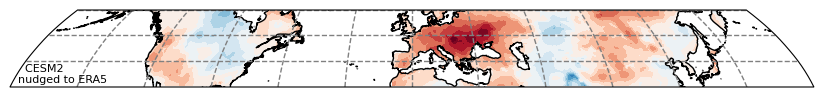

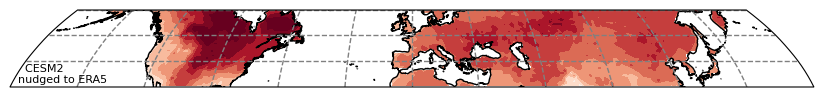

In [10]:
maxabs = 0.6
levels = np.linspace(-maxabs,maxabs,17)
for name,d in component_dict.items():
    fig,ax = plt.subplots(nrows=1, figsize=(12, 1), subplot_kw={'projection': cartopy.crs.Robinson()})
    ax.coastlines()
    ax.set_extent([-180, 180, 30, 60], crs=cartopy.crs.PlateCarree())
    trend = component_dict[name]['trend']
    trend = trend.roll(lon=int(0.5*trend.shape[1]), roll_coords=True)
    im = ax.contourf(trend.lon, trend.lat, trend * 10, transform=cartopy.crs.PlateCarree(), cmap='RdBu_r', levels=levels, extend='both')
    ax.annotate('  CESM2\nnudged to ERA5', xy=(0.01,0.05), xycoords='axes fraction', fontsize=8)

    ax.set_facecolor('w')

    gl = ax.gridlines(crs=cartopy.crs.PlateCarree(), draw_labels=False,
                linewidth=1, color='gray', alpha=1, linestyle='--')
    gl.xlocator = matplotlib.ticker.FixedLocator(np.arange(-180,200,30,'int'))
    gl.ylocator = matplotlib.ticker.FixedLocator(np.arange(40,61,10,'int'))

    plt.savefig(f"../plots/CESM2_nudged_to_ERA5_trends_1979-2023_{name}.pdf", bbox_inches='tight')
    plt.savefig(f"../plots/CESM2_nudged_to_ERA5_trends_1979-2023_{name}.png", bbox_inches='tight', dpi=300)

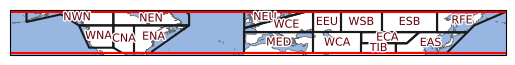

In [8]:
from _srex_regions import get_mask,plot_regions
mask,regions = get_mask(trend, ignored_regions=['GIC','NAO','NPO','NCA'])
plot_regions(regions[mask.region.values])

In [9]:
weights = np.cos(np.deg2rad(trend.lat))
land_mask = regionmask.defined_regions.natural_earth_v5_0_0.land_110.mask(trend.lon, trend.lat)
land_mask.values[np.isfinite(land_mask)] = 1

In [10]:
for name,d in component_dict.items():
    trend = component_dict[name]['trend']
    component_dict[name]['trend_reg'] = regional_trends = xr.DataArray(dims=["region"], coords = dict(region=mask.abbrevs))
    for reg in regional_trends.region:
        y_ = trend * mask.loc[mask.abbrevs == reg] * land_mask
        component_dict[name]['trend_reg'].loc[reg] = y_.weighted(weights).mean() * 10

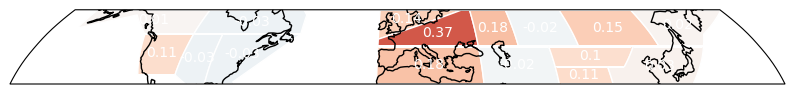

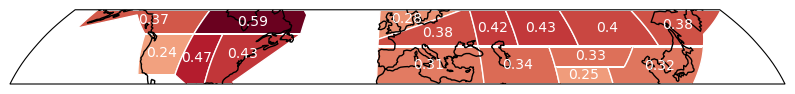

In [11]:
cmap = matplotlib.colormaps.get_cmap('RdBu_r')
norm = matplotlib.colors.Normalize(vmin=-0.6, vmax=0.6)

for name,d in component_dict.items():
    regional_trends = component_dict[name]['trend_reg']
    fig,ax = plt.subplots(nrows=1, figsize=(10, 1), subplot_kw={'projection': cartopy.crs.Robinson()})
    ax.set_extent([-180,180,30,60], crs=cartopy.crs.PlateCarree())
    ax.coastlines(zorder=10, resolution='110m')
    for reg_name,polygon in zip(regions.abbrevs, regions.polygons):
        x = regional_trends.loc[reg_name].values.mean()
        ax.add_geometries(polygon, cartopy.crs.PlateCarree(),
                        facecolor=cmap(norm(x)), edgecolor='w')
        lon,lat = np.array(polygon.centroid.xy).flatten()
        if lat > 60:
            lat = 57
        ax.annotate(round(x,2), (lon,lat), transform=cartopy.crs.PlateCarree(), ha='center', va='center', color='w', zorder=11)
    #ax.spines['geo'].set_edgecolor('white')
    plt.savefig(f"../plots/CESM2_nudged_to_ERA5_trends_1979-2023_srex_{name}.pdf", bbox_inches='tight')
    plt.savefig(f"../plots/CESM2_nudged_to_ERA5_trends_1979-2023_srex_{name}.png", bbox_inches='tight', dpi=300)